# Notebook for structure generation and parameterization of small-molecule plasticizers

In [1]:
import logging
logging.basicConfig(
    level=logging.INFO
)

from pathlib import Path

WORKING_DIR : Path = Path('plasticizer_project')
WORKING_DIR.mkdir(exist_ok=True)

## Functionalizing and parameterizing plasticizers

In [2]:
from typing import Optional
from rdkit import Chem

from polymerist.polymers.monomers import specification
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.bonding.substitution import saturate_ports
from polymerist.rdutils.bonding import portlib


def functionalize_phenyl(substituent_map : dict[int, Chem.Mol], default_cap : Chem.Mol=None) -> Chem.Mol:
    '''Accepts a dict keyed by port flavors 1-6 (corresponding to phenyl substitution sites) and mapping to single-port cap fragments. 
    Returns the resulting substituted benzene-derived molecule'''
    if default_cap is None:
        default_cap = Chem.MolFromSmiles('[7*]-[H]', sanitize=False) # use lone hydrogen as default cap
        Chem.SanitizeMol(default_cap, sanitizeOps=specification.SANITIZE_AS_KEKULE)

    phenyl_template_smiles = 'c([1*])1c([2*])c([3*])c([4*])c([5*])c([6*])1'
    phenyl_template = Chem.MolFromSmiles(phenyl_template_smiles, sanitize=False)
    Chem.SanitizeMol(phenyl_template, sanitizeOps=specification.SANITIZE_AS_KEKULE)

    for port in portlib.get_ports(phenyl_template):
        cap_group = substituent_map.get(port.flavor, default_cap)
        if cap_group is not None:
            cap_port = portlib.get_single_port(cap_group)
            flavor_pair = (port.flavor, cap_port.flavor)
            portlib.Port.bondable_flavors.insert(flavor_pair)

            phenyl_template = saturate_ports(phenyl_template, cap=cap_group, flavor_to_saturate=port.flavor)
            molwise.clear_atom_map_nums(phenyl_template, in_place=True)
            Chem.SanitizeMol(phenyl_template, sanitizeOps=specification.SANITIZE_AS_KEKULE)

            portlib.Port.bondable_flavors.pop(flavor_pair) # deregister flavor pair once substitution is made

    return phenyl_template

INFO:rdkit:Enabling RDKit 2023.09.5 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


[16:00:17] WARNING: not removing hydrogen atom with dummy atom neighbors
INFO:polymerist.smileslib.functgroups:Loading functional group SMARTS data from LUT


hydrogen


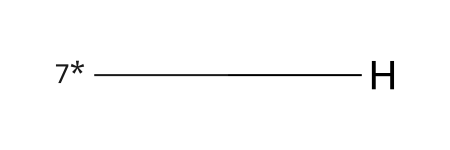

methoxyl


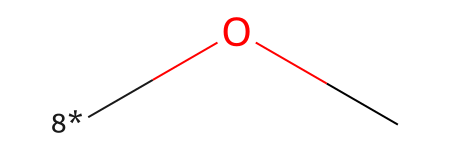

butyl_ester


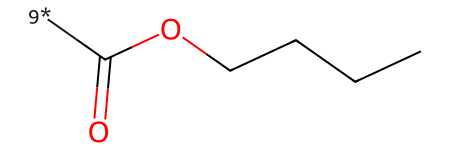

hexan-3-yl_ester


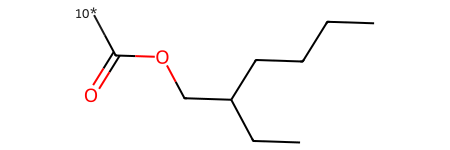

In [3]:
sidechain_smi = {
    'hydrogen'         : '[7*]-[H]',
    'methoxyl'         : '[8*]OC',
    'butyl_ester'      : '[9*]C(=O)OCCCC',
    'hexan-3-yl_ester' : '[10*]C(=O)OCC(CC)CCCC',
}

substituent_templates = {}
for fragname, smi in sidechain_smi.items():
    mol = Chem.MolFromSmiles(smi, sanitize=False)
    Chem.SanitizeMol(mol, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    print(fragname)
    display(mol)
    substituent_templates[fragname] = mol

In [4]:
substituents : tuple[dict[int, Chem.Mol]] = (
    {
        1 : substituent_templates['butyl_ester'],
        4 : substituent_templates['butyl_ester'],
    },
    {
        1 : substituent_templates['butyl_ester'],
        2 : substituent_templates['butyl_ester'],
    },
    {
        1 : substituent_templates['hexan-3-yl_ester'],
        4 : substituent_templates['hexan-3-yl_ester'],
    },
    {
        1 : substituent_templates['hexan-3-yl_ester'],
        2 : substituent_templates['hexan-3-yl_ester'],
    },
    {
        1 : substituent_templates['butyl_ester'],
        2 : substituent_templates['methoxyl'],
        4 : substituent_templates['butyl_ester'],
    },
    {
        1 : substituent_templates['hexan-3-yl_ester'],
        2 : substituent_templates['methoxyl'],
        4 : substituent_templates['hexan-3-yl_ester'],
    },
    {
        1 : substituent_templates['butyl_ester'],
        2 : substituent_templates['methoxyl'],
        4 : substituent_templates['butyl_ester'],
        6 : substituent_templates['methoxyl'],
    },
    {
        1 : substituent_templates['hexan-3-yl_ester'],
        2 : substituent_templates['methoxyl'],
        4 : substituent_templates['hexan-3-yl_ester'],
        6 : substituent_templates['methoxyl'],
    },
)

In [5]:
from pathlib import Path

from rdkit.Chem.AllChem import EmbedMolecule
from openff.toolkit import Molecule, Topology

from polymerist.genutils.textual.encoding import hash_as_alphanumeric
from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.smileslib.chemdbqueries import get_property_from_smiles
from polymerist.mdtools.openfftools import topology, TKREGS
from polymerist.mdtools.openfftools.partialcharge.molchargers import MolCharger


# build execution
charge_method : str = 'Espaloma-AM1-BCC'
CHARGER = MolCharger.subclass_registry[charge_method]()

plast_dir : Path = WORKING_DIR / 'plasticizers'
plast_dir.mkdir(exist_ok=True)

for substituent_map in substituents:
    plasticizer = functionalize_phenyl(substituent_map, default_cap=substituent_templates['hydrogen'])
    plasticizer_smi = Chem.MolToSmiles(plasticizer, canonical=True)
    plasticizer_smi_exp = specification.expanded_SMILES(plasticizer_smi, assign_map_nums=False)

    plasticizer_full = Chem.MolFromSmiles(plasticizer_smi_exp, sanitize=False)
    Chem.SanitizeMol(plasticizer_full, sanitizeOps=specification.SANITIZE_AS_KEKULE)
    errcode = EmbedMolecule(plasticizer_full)
    assert(errcode == 0)
    
    offmol = Molecule.from_rdkit(plasticizer_full, allow_undefined_stereo=True)
    iupac_name = get_property_from_smiles(plasticizer_smi, prop_name='iupac_name')
    if iupac_name is not None:
        offmol.name = iupac_name
    cmol = CHARGER.charge_molecule(offmol, in_place=False)

    hashname = hash_as_alphanumeric(plasticizer_smi)
    topo_path = assemble_path(plast_dir, hashname, extension='sdf')
    topology.topology_to_sdf(topo_path, cmol.to_topology(), toolkit_registry=TKREGS['The RDKit'])

INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Assigning partial charges via the "Espaloma-AM1-BCC" method
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name 'dibutyl benzene-1,4-dicarboxylate' and SMILES '[H]c1c(c(c(c(c1C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])[H])[H])C(=O)OC([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])[H]'' has 1 conformers, but charge method 'espaloma-am1bcc' expects exactly 0.
  self._check_n_conformers(
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Successfully assigned "Espaloma-AM1-BCC" charges
INFO:polymerist.mdtools.openfftools.topology:Successfully serialized SDF Topology to plasticizer_project/p

# Generating single oligomers for melts

In [6]:
from rdkit import Chem
import numpy as np

import mdtraj as mdt
from openff.toolkit import Topology, Molecule, ForceField
from openff.units import unit as offunit
from openmm.unit import femtosecond, picosecond, nanosecond, kelvin, atmosphere
from openmm.unit import Quantity, Unit, nanometer

from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.unitutils.interop import openmm_to_openff, openff_to_openmm

from polymerist.rdutils.rdcoords.tiling import rdmol_effective_radius
from polymerist.polymers.monomers import specification, MonomerGroup
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb

from polymerist.mdtools.openfftools import topology, boxvectors
from polymerist.mdtools.openfftools.partialcharge.molchargers import MolCharger

from polymerist.mdtools.openmmtools.parameters import SimulationParameters, ThermoParameters, IntegratorParameters, ReporterParameters
from polymerist.mdtools.openmmtools.thermo import EnsembleFactory
from polymerist.mdtools.openmmtools.execution import run_simulation_schedule

from polybuild_utils import generate_uniform_subpopulated_lattice, initialize_polymer_progress

### Simulation and topology parameters

In [7]:
# topology parameters
DOP : int = 100
MAX_NUM_ATOMS : int = 80_000
substructs = {
    'polyvinylchloride' : {
        'MID'   : '*C(Cl)C*',
        'TERM1' : 'ClC=C*',
        'TERM2' : '*C(Cl)C',
    },
    # 'polylactic_acid' : {
    #     'MID'   : '*C(C)C(=O)O*',
    #     'TERM1' : 'OC(C)C(=O)O*',
    #     'TERM2' : '*C(C)C(=O)O',
    # },
}

# global MD setup parameters
switching_function : bool = False
exclusion : Quantity = 0.0 * nanometer 
nonbond_cutoff : Quantity = 0.9 * nanometer

charge_method : str = 'Espaloma-AM1-BCC'
force_field_name : str = 'openff_unconstrained-2.0.0.offxml' # 'openff-2.0.0.offxml'

sim_params = SimulationParameters( # for conformer anneal
    integ_params=IntegratorParameters(
        time_step=1*femtosecond,
        total_time=1*nanosecond,
        num_samples=100
    ),
    thermo_params=ThermoParameters(
        ensemble='NVT',
        temperature=600*kelvin,
        friction_coeff=1*picosecond**-1,
    ),
    reporter_params=ReporterParameters(),
)

In [8]:
# pre-init from parameters
CHARGER = MolCharger.subclass_registry[charge_method]()
FORCEFIELD = ForceField(force_field_name)
ENSFAC = EnsembleFactory.from_thermo_params(sim_params.thermo_params)

min_box_dim : Quantity = 2 * nonbond_cutoff # should be at least twice the nonbonded cutoff to avoid self-interaction
MIN_BBOX = openmm_to_openff(min_box_dim * np.eye(3))

ommsim_schedule = {
    'high_T_anneal' : sim_params
}

INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert vdW section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted vdW section from 0.3 to 0.4. `method="cutoff"` is now split into `periodic_method="cutoff"` and `nonperiodic_method="no-cutoff"`.
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Attempting to up-convert Electrostatics section from 0.3 to 0.4
INFO:openff.toolkit.typing.engines.smirnoff.parameters:Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.


In [9]:
oligomer_dir = WORKING_DIR / 'polymers'
oligomer_dir.mkdir(exist_ok=True)

topology_dir = WORKING_DIR / 'topologies'
topology_dir.mkdir(exist_ok=True)

sim_params_path = assemble_path(oligomer_dir, 'sim_params', extension='json')
sim_params.to_file(sim_params_path)

orient_kwds = ['head', 'tail']
for polymer_name, frag_dict in substructs.items():
    olig_chem_dir = oligomer_dir / polymer_name
    olig_chem_dir.mkdir(exist_ok=True)

    melt_chem_dir = topology_dir / polymer_name
    melt_chem_dir.mkdir(exist_ok=True)

    # CLEAN UP SMILES MONOMERS INTO MONOMER SPEC-COMPLIANT SMARTS
    monomers = {}
    term_orient = {}
    for orient_name, smi in frag_dict.items():
        resname = f'{polymer_name}_{orient_name}'

        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=True)
        sma = specification.compliant_mol_SMARTS(exp_smi)
        mol = Chem.MolFromSmarts(sma)
        # display(mol)

        monomers[resname] = [sma]
        if 'TERM' in orient_name:
            rank = int(orient_name[-1]) - 1
            term_orient[resname] = orient_kwds[rank]

    # INITIALIZE AND SAVE MONOMER GROUP
    monogrp = MonomerGroup(monomers=monomers, term_orient=term_orient)
    monogrp_path = assemble_path(olig_chem_dir, polymer_name, postfix='fragments', extension='json')
    monogrp.to_file(monogrp_path)

    # GENERATE INITIAL COORDINATES USING MBUILD, SAVE TO PDB
    chain = build_linear_polymer(monogrp, DOP=DOP, energy_minimize=False)
    pdb_path = assemble_path(olig_chem_dir, polymer_name, extension='pdb')
    mbmol_to_openmm_pdb(pdb_path, chain)

    # LOAD CHEMICAL INFO INTO PDB, ASSIGN PARTIAL CHARGES, AND SAVE TO SDF
    offtop = Topology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
    offmol = topology.get_largest_offmol(offtop)
    cmol = CHARGER.charge_molecule(offmol)
    ctop = cmol.to_topology()

    sdf_path = assemble_path(olig_chem_dir, polymer_name, extension='sdf')
    topology.topology_to_sdf(sdf_path, ctop)

    # CREATE INTERCHANGE AND OPENMM ANNEAL SIMULATION
    ommdir = olig_chem_dir / f'{polymer_name}_openmm'
    ommdir.mkdir(exist_ok=True)
    
    omminc = FORCEFIELD.create_interchange(ctop, charge_from_molecules=[cmol])
    history = run_simulation_schedule(
        ommdir,
        schedule=ommsim_schedule,
        init_top=omminc.to_openmm_topology(),
        init_sys=omminc.to_openmm_system(combine_nonbonded_forces=False),
        init_pos=openff_to_openmm(omminc.positions),
        return_history=True
    )

    # EXTRACT POSITIONS OF FINAL ANNEAL SNAPSHOT AND SET AS NEW CONFORMER
    sim_paths = history[list(ommsim_schedule.keys())[-1]]['paths']
    traj = mdt.load(sim_paths.trajectory_path, top=sim_paths.topology_path)
    final_conformer_coords = traj.xyz[-1, :, :] # take last frame, all atoms, all dimensions as final conformer
    final_conformer_offunit = (final_conformer_coords * offunit.nanometer)

    ctop.set_positions(final_conformer_offunit)
    conf_sdf_path = assemble_path(olig_chem_dir, polymer_name, postfix='annealed', extension='sdf')
    topology.topology_to_sdf(conf_sdf_path, ctop)

    # SIZE LATTICE FOR TARGET NUMBER OF ATOMS CAP
    ## need to reload to avoid issues when exporting largest molecule to RDKit (something gets messed up with conformers during conversion)
    ctop = topology.topology_from_sdf(conf_sdf_path)
    cmol = topology.get_largest_offmol(ctop)
    
    int_lattice = generate_uniform_subpopulated_lattice(max_num_atoms=MAX_NUM_ATOMS, num_atoms_in_mol=cmol.n_atoms)
    r_eff = rdmol_effective_radius(cmol.to_rdkit())
    lattice = int_lattice.linear_transformation(2.0*r_eff*np.eye(3), as_coords=True) # scale integer lattice my effective diameter

    # PACK OLIGOMERS ONTO LATTICE
    tiled_offtop = topology.topology_from_molecule_onto_lattice(cmol, lattice_points=lattice.points, rotate_randomly=True)
    tiled_sdf_path = assemble_path(melt_chem_dir, polymer_name, postfix=f'{MAX_NUM_ATOMS}_atoms', extension='sdf')
    topology.topology_to_sdf(tiled_sdf_path, tiled_offtop)

    tiled_pdb_path = assemble_path(melt_chem_dir, polymer_name, postfix=f'{MAX_NUM_ATOMS}_atoms', extension='pdb')
    tiled_offtop.to_file(tiled_pdb_path, file_format='pdb') # purley for visualization

    # SET BOX SIZE AND NONBONDED PARAMETERS
    top_box_vectors = boxvectors.get_topology_bbox(tiled_offtop) # determine tight box size
    top_box_vectors = boxvectors.pad_box_vectors_uniform(top_box_vectors, exclusion) # apply periodic box (with padding) to Interchange
    top_box_vectors = np.maximum(MIN_BBOX, top_box_vectors) # enusre the box is no smaller than the minimum determined by the cutoff distance

    inc_topo = FORCEFIELD.create_interchange(tiled_offtop, charge_from_molecules=[cmol])
    inc_topo.box = top_box_vectors # apply periodic box to Interchange

    # PACK SMALL MOLECULE LIGANDS IN BETWEEN LATTICE
    ...

    # CREATE FINAL INTERCHANGE, WRITE LAMMPS FILES
    ...

INFO:polymerist.polymers.building:Using pre-defined terminal group orientation {'polyvinylchloride_TERM1': 'head', 'polyvinylchloride_TERM2': 'tail'}
INFO:polymerist.polymers.building:Registering middle monomer polyvinylchloride_MID (block identifier "A")
INFO:polymerist.polymers.building:Registering terminal monomer polyvinylchloride_TERM1 (orientation "head")
INFO:polymerist.polymers.building:Registering terminal monomer polyvinylchloride_TERM2 (orientation "tail")
INFO:polymerist.polymers.building:Assembling linear polymer chain with 100 monomers (600 atoms)
INFO:polymerist.polymers.building:Successfully assembled linear polymer chain with 100 monomers (600 atoms)
INFO:polymerist.mdtools.openfftools.partialcharge.molchargers:Assigning partial charges via the "Espaloma-AM1-BCC" method
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/espaloma_charge/openff_wrapper.py:112: IncorrectNumConformersWarning: Molecule 'Molecule with name '' and SMILES '[H]/C(=C(/[H])\

In [10]:
inc_topo

Interchange with 7 collections, periodic topology with 79800 atoms.

In [20]:
plast_wt_fract : float = 0.10

melt_mass = sum(atom.mass for atom in tiled_offtop.atoms)
plast_mass = plast_wt_fract * melt_mass

for plast_

In [ ]:
melt_mass

831231.3932995328 <Unit('dalton')>

In [22]:
p = WORKING_DIR / 'plasticizers' / '6gQskIFGlwxoXvTu9OZRLg.sdf'
plast_offtop = topology.topology_from_sdf(p)
plast_offmol = topology.get_largest_offmol(plast_offtop)

INFO:polymerist.mdtools.openfftools.topology:Loading serialized SDF Topology from plasticizer_project/plasticizers/6gQskIFGlwxoXvTu9OZRLg.sdf
